# Natural Gas Price Analysis

In [39]:
# Initial imports
import os
import pandas as pd
import numpy as np
from pathlib import Path
import datetime as dt
from datetime import datetime
from sklearn.linear_model import LinearRegression


# API Imports
from dotenv import load_dotenv

#Dashboarding Imports
import panel as pn
from panel.interact import interact
from panel import widgets

#Third Party Imports
from MCForecastTools import MCSimulation

#Project Helper file
from helper import *

#Plotting/Pyviz Import
import holoviews as hv
import plotly.express as px
pn.extension('plotly')
import hvplot.pandas
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings('ignore')
pn.extension()


In [40]:
# Load .env enviroment variables
load_dotenv()
value_not_exists = "EIA_API_KEY", "EIA API KEY does not exist"
eia_api_key = os.getenv("EIA_API_KEY", value_not_exists)
if eia_api_key == value_not_exists:
    print("Enviroment Variable for EIA API KEY is not found, please verify your .env file")
    raise KeyError("Enviroment Variable for EIA API KEY is not found, please verify your .env file") 

# Set Start date and End Date
start_date = "2010-01-01"
end_date = "2014-12-30"


## Fetch & Clean Data 

In [41]:
# fetch stock prices between start and end date using yfinance and convert to data frame
df_historic = yfinance_tickers_data("NG=F", start_date, end_date)
#To display the title of the stock historic price
pn.Column(f"### Daily Closing Price of Natural Gas (NG=F) between {start_date} & {end_date}", pn.Row(df_historic.head(), width = 200), width = 900)


Column(width=900)
    [0] Markdown(str)
    [1] Row(width=200)
        [0] DataFrame(DataFrame)

In [42]:
# Read Natural Gas Storage Data
# set storage data file path
df_storage_file = Path(r"Data\NG_STOR_WKLY_S1_W.csv")
# Reading Storage data and convert it to dataframe
df_storage_data = pd.read_csv(df_storage_file,index_col="Date", infer_datetime_format=True, parse_dates=True)
#Display Title
display(pn.Column("### Weekly Storage of  Natural Gas Storage Data for US", width=900))
#Verify the data
df_storage_data.head()


Column(width=900)
    [0] Markdown(str)

,48 States,East Region,Midwest Region,Mountain Region,Pacific Region,South Central,Salt South Central,Non Salt South Central
Date,,,,,,,,
2010-01-01,3117,769,900,195,268,985,159,826
2010-01-08,2850,703,820,185,257,886,123,763
2010-01-15,2607,642,750,176,246,793,91,702
2010-01-22,2521,616,710,171,235,789,102,687
2010-01-29,2406,582,661,164,221,779,108,671


In [43]:
# aggregate the weekly storage data into monthly, by grouping by year.month and avaraging
df_storage_monthly = format_strorage_monthly(df_storage_data)
# Display the dataframe with title for demo purposes
pn.Column(f"### Monthly Natural Gas Storage Data by Region between {start_date} & {end_date}", df_storage_monthly.head(), width = 900)


Column(width=900)
    [0] Markdown(str)
    [1] DataFrame(DataFrame)

In [44]:
region_dfs = load_data(region_info, eia_api_key, start_date, end_date, df_storage_monthly, df_historic)


In [45]:
# Verify Data closing price/temparaure data for PA
region_dfs["PA"]["price_temperature"].head()

,Close,Maximum,Minimum,Avg Temp
Date,,,,
2010-01-04,5.884,23,16,19.5
2010-01-05,5.637,24,19,21.5
2010-01-06,6.009,26,22,24.0
2010-01-07,5.806,24,21,22.5
2010-01-08,5.749,23,11,17.0


In [46]:
region_dfs["PA"]["combined"].head()

,Close,Maximum,Minimum,Avg Temp,Industrial Consumption,Residential Consumption,Storage
Date,,,,,,,
2010-01-01,5.598895,31.368421,20.263158,25.815789,21745,43694,3312
2010-02-01,5.214000,33.210526,21.789474,27.500000,19824,39423,1809
2010-03-01,4.300000,53.826087,32.826087,43.326087,18134,27737,1360
2010-04-01,4.083619,67.666667,42.333333,55.000000,16012,13190,1880
2010-05-01,4.154050,74.100000,51.800000,62.950000,15166,8276,1916


## Visual Data Analysis

In [47]:
# Plot the closing price vs temperature for the state, lagging price and temeparure by shift if applicable
# input :
#       state : the state for the plot
#       lag_price : a boolean to lag price by shift if True
#       lag_temperature : a boolean to lag temeparure  by shift if True
#       shift : the perios in months to shift, max of +/- 3 months
# output : plotly go figure
def plot_price_temperature(state, lag_price, lag_temperature, shift):
    
    # Get a copy of the slosing price/temperature data for the state
    df = region_dfs[state]["price_temperature"].copy()
    
    
    # If lag temeparure is true, shift it 
    if lag_temperature:
        df["Avg Temp"] = df["Avg Temp"].shift(periods=30 * shift)
    # If lag temeparure is true, shift it 
    if lag_price:
        df["Close"] = df["Close"].shift(periods=30 * shift)
    
    # make the plot with secondary axis
    fig = make_subplots(
                    specs=[[{"secondary_y": True}],
                           ])
    # 1st Plot closing price vs time
    fig.add_trace(
        go.Scatter( x=df.index, y=df["Close"], name="Closing Price", line=dict(color="#0000ff")),
        row=1, col=1, secondary_y=False
    )
    # 2nd Plot average temperarure as secondary y axes, ploted on the same plot
    fig.add_trace(
        go.Scatter( x=df.index, y=df["Avg Temp"], name="Average Temperature",  line=dict(color="#ff0000")),
        row=1, col=1, secondary_y=True, )

   
    
    # Set x-axis title
    fig.update_xaxes(title_text="Date")

    # Set y-axes titles
    fig.update_yaxes(title_text="Closing Price ($)", secondary_y=False)
    fig.update_yaxes(title_text="Temperature °F", secondary_y=True)
    
    # Set layout properties
    fig.update_layout(
    title_text = f"{state} Relationship between Daily Natural Gas Closing Prices & Average Temperature",
    title_y = 1,
    title_x = 0.05,        
    title_pad_t = 20,
    title_pad_b = 50,
    title_xanchor = "auto", 
    plot_bgcolor = "rgb(255,255,255)",        
    autosize=False,
    width=1000,
    height=400,
    margin=dict(
        l=50,
        r=50,
        b=10,
        t=60,
        pad=2
    )
    )
    # format x-axes
    fig.update_xaxes(tickangle=90,
                 tickmode = 'array',
                 tickvals = df.index[0::28],
                 tickformat = '%m-%Y', showgrid= False, ticks="inside", showline=True, linewidth=2, linecolor='black')
    #format y-axes
    fig.update_yaxes( showgrid= False, ticks="inside", showline=True, linewidth=2, linecolor='black')

    # return the figure
    return  fig




# Create the intercat panel for the plot
price_temp = pn.interact(plot_price_temperature, 
                         state = pn.widgets.Select(name='State', options=states_list), 
                         lag_price = pn.widgets.Checkbox(name='Lag Closing Price') , 
                         lag_temperature =  pn.widgets.Checkbox(name='Lag Temperature'),  
                         shift = pn.widgets.IntSlider(name="Lag Period (in months)", start= -3, end=3, step=1, value=0) )
col_price_temp = pn.Column(pn.Row(price_temp[0][0], price_temp[0][1], price_temp[0][2], price_temp[0][3], width=800, height=50), price_temp[1][0])
col_price_temp

Column
    [0] Row(height=50, sizing_mode='fixed', width=800)
        [0] Select(name='State', options=['PA', 'CT', 'IL', ...], value='PA')
        [1] Checkbox(name='Lag Closing Price')
        [2] Checkbox(name='Lag Temperature')
        [3] IntSlider(end=3, name='Lag Period (in months)', start=-3, value_throttled=0)
    [1] Plotly(Figure, name='interactive02567')

In [48]:
# Plot the closing price vs temperature for the state, lagging price and temeparure by shift if applicable
# input :
#       region : the region i.e. US or State for the plot
#       lag_closing_price : a boolean to lag closing price by shift if True
#       lag_storage : a boolean to lag storage  by shift if True
#       shift_period : the period in months to shift, max of +/- 3 months
# output : plotly go figure
def plot_storage_closingprice(region, lag_closing_price, lag_storage, shift_period):
    
    # fetch the data for the region
    df = region_dfs[region]["combined"].copy()  
    
    #df = df.reset_index()
    
    # Shift storage ???
    if lag_storage:
        df["Storage"] = df["Storage"].shift(periods=shift_period)
    # Shift Clsoing Price ???    
    if lag_closing_price:
        # lag it by shift_period
        df["Close"] = df["Close"].shift(periods=shift_period)        
    #display(df["Avg Temp"])
    fig = make_subplots(
                    specs=[[{"secondary_y": True}],
                           ])
    #display(df)
    # Top left
    fig.add_trace(
        go.Scatter( x=df.index, y=df["Storage"], name="Monthly Storage",  line=dict(color="#ff0000")),
        row=1, col=1, secondary_y=False, )

    fig.add_trace(
        go.Scatter( x=df.index, y=df["Close"], name="Closing Price", line=dict(color="#0000ff")),
        row=1, col=1, secondary_y=True
    )

    
    # Set x-axis title
    fig.update_xaxes(title_text="Date")

    # Set y-axes titles
    fig.update_yaxes(title_text="Storage", secondary_y=True)
    fig.update_yaxes(title_text="Closing Price ($)", secondary_y=False)
    
    
    # update layout and set backround to white, width, height and margins
    fig.update_layout(
    title_text = f"   {region} Monthly Relationship between Natural Gas Closing Price & Storage",
    title_y = 1,
    title_x = 0.1,
    title_pad_t = 20,
    title_pad_b = 50,
    title_xanchor = "left", 
    plot_bgcolor = "rgb(255,255,255)",        
    autosize=False,
    width=1000,
    height=400,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=60,
        pad=4
    )      
    )
    # configure axes, set the tciks to months of format %m%Y
    fig.update_xaxes(tickangle=90,
                 tickmode = 'array',
                 tickvals = df.index[0::2],
                 tickformat = '%m-%Y', showgrid= False, ticks="inside", showline=True, linewidth=2, linecolor='black')
    # configure yaxes
    fig.update_yaxes( showgrid= False, ticks="inside", showline=True, linewidth=2, linecolor='black')

    
    return  fig



# create interact panel for the plot
storage_price = pn.interact(plot_storage_closingprice, 
                            region = pn.widgets.Select(name='Region', options=region_list), 
                            lag_closing_price = pn.widgets.Checkbox(name='Lag Closing Price') , 
                            lag_storage = pn.widgets.Checkbox(name='Lag Storage'),  
                            shift_period = pn.widgets.IntSlider(name="Lag Period (in months)", start= -3, end=3, step=1, value=0) )

# re-arrange the columns
col_storage_price = pn.Column(pn.Row(storage_price[0][0], storage_price[0][1], storage_price[0][2], storage_price[0][3], width=700, height=50), storage_price[1][0])
col_storage_price


Column
    [0] Row(height=50, sizing_mode='fixed', width=700)
        [0] Select(name='Region', options=['US', 'PA', 'CT', ...], value='US')
        [1] Checkbox(name='Lag Closing Price')
        [2] Checkbox(name='Lag Storage')
        [3] IntSlider(end=3, name='Lag Period (in months)', start=-3, value_throttled=0)
    [1] Plotly(Figure, name='interactive02581')

In [49]:

# create another interact panel for the plot, as a single interact does not work in two panels
price_storage = pn.interact(plot_storage_closingprice, region = pn.widgets.Select(name='Region', options=region_list), 
                            lag_closing_price = pn.widgets.Checkbox(name='Lag Closing Price') , 
                            lag_storage = pn.widgets.Checkbox(name='Lag Storage'),  
                            shift_period = pn.widgets.IntSlider(name="Lag Period (in months)", start= -3, end=3, step=1, value=0) )

# re-arrange widgets
col_price_storage = pn.Column(pn.Row(price_storage[0][0], price_storage[0][1], price_storage[0][2], price_storage[0][3], width=700, height=50), price_storage[1][0])
#col_price_storage


In [50]:
# Plot the storage vs temperature for the state, lagging storage and temeparure by shift_period if applicable
# input :
#       region : the region i.e. US or State for the plot
#       lag_temperature : a boolean to lag temperature by shift_period if True
#       lag_storage : a boolean to lag storage  by shift_period if True
#       shift_period : the period in months to shift, max of +/- 3 months
# output : plotly go figure
def plot_storage_temperature(state, lag_temperature, lag_storage, shift_period):
    # Fetch a copy of data for the state
    df = region_dfs[state]["combined"].copy()
    # reset index
    df = df.reset_index()
    
    # Shift temperarure by -3 months
    if lag_temperature:
        df["Avg Temp"] = df["Avg Temp"].shift(periods=shift_period)
    if lag_storage:    
        df["Storage"] = df["Storage"].shift(periods=shift_period)    
    # Create a single subplot
    fig = make_subplots(rows=1, cols=1,
                    specs=[[{"secondary_y": True}],
                           ])
    
    # create the ave temp vs date - 1st plot on secondary y axis
    fig.add_trace(
        go.Scatter( x=df.index, y=df["Avg Temp"], name="Average Temperature",  line=dict(color="#ff0000")),
        row=1, col=1, secondary_y=True )
    # create the storage vs date - 2nd plot on primary y axis
    fig.add_trace(
        go.Scatter( x=df.index, y=df["Storage"], name="Storage", line=dict(color="#0000ff")),
        row=1, col=1, secondary_y=False
    )

    
    # Set x-axis title
    fig.update_xaxes(title_text="Date")

    # Set y-axes titles
    fig.update_yaxes(title_text="Temperature °F", secondary_y=True)
    fig.update_yaxes(title_text="Storage", secondary_y=False)
    
    
    # configure the layout
    fig.update_layout(
    title_text = f"{state} Relationship between Monthly Natural Gas Storage & Temperature",
    title_y = 1,
    title_x = 0.1,        
    title_pad_t = 20,
    title_pad_b = 50,
    title_xanchor = "auto", 
    plot_bgcolor = "rgb(255,255,255)",        
    autosize=False,
    width=1000,
    height=400,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=60,
        pad=4
    )      
    )
    # configure the xaxes
    fig.update_xaxes(tickangle=90,
                 tickmode = 'array',
                 tickvals = df.index[0::2], 
                 tickformat = '%m-%Y', showgrid= False, ticks="inside", showline=True, linewidth=2, linecolor='black')
    # configure the yaxes    
    fig.update_yaxes( showgrid= False, ticks="inside", showline=True, linewidth=2, linecolor='black')

    
    return  fig



#interact_panel = pn.interact(plot_storage_temperature,state=list(region_info.keys())[-(len(region_info.keys()) - 1):]  )




storage_temp = pn.interact(plot_storage_temperature , state=pn.widgets.Select(name='State', options=states_list), 
                           lag_temperature = pn.widgets.Checkbox(name='Lag Temperature'), 
                           lag_storage = pn.widgets.Checkbox(name='Lag Storage'), 
                           shift_period = pn.widgets.IntSlider(name="Lag Period (in months)", start= -3, end=3, step=1, value=0)) 

col_storage_temp = pn.Column(pn.Row(storage_temp[0][0], storage_temp[0][1], storage_temp[0][2], storage_temp[0][3], width=600, height=50), storage_temp[1][0])

col_storage_temp




Column
    [0] Row(height=50, sizing_mode='fixed', width=600)
        [0] Select(name='State', options=['PA', 'CT', 'IL', ...], value='PA')
        [1] Checkbox(name='Lag Temperature')
        [2] Checkbox(name='Lag Storage')
        [3] IntSlider(end=3, name='Lag Period (in months)', start=-3, value_throttled=0)
    [1] Plotly(Figure, name='interactive02607')

In [51]:
# Plot the consumption vs temperature for the state
# input :
#       state : the state  for the plot
# output : plotly go figure
def plot_comsumption_temperaure_plotly(state):
    
    # Fetch the data for the state
    df = region_dfs[state]["combined"].copy()  
    

    str_res = "Residential Consumption"
    str_indus = "Industrial Consumption"
    # Title of each plot
    str_res_title = f"{state} - Relationship b/w Resid. Consumption & Temperature"
    str_indus_title = f"{state} - Relationship b/w Indus. Consumption & Temperature"

    df[str_res] = df[str_res] 
    df[str_indus] = df[str_indus] 
    
    
    fig = make_subplots(rows=1, cols=2,
                    specs=[[{"secondary_y": True} , {"secondary_y": True}],
                           ],  subplot_titles = [str_res, str_indus])

    #  left plot - residential consmption
    fig.add_trace(
        go.Scatter( x=df.index, y=df[str_res], name=str_res,  line=dict(color="#ff0000")),
        row=1, col=1, secondary_y=False)
    # plot for avg. temeparure on secondary axes
    fig.add_trace(
        go.Scatter( x=df.index, y=df["Avg Temp"], name="Temperature", line=dict(color="#0000ff")),
        row=1, col=1, secondary_y=True
    )

    #  right plot - industrial consumption
    fig.add_trace(
        go.Scatter( x=df.index, y=df[str_indus], name=str_indus , line=dict(color="#007f00")),
        row=1, col=2, secondary_y=False)
    # plot for avg. temeparure on secondary axes
    fig.add_trace(
        go.Scatter(x=df.index, y =df["Avg Temp"], name="Temperature", line=dict(color="#0000ff")),
        row=1, col=2, secondary_y=True
    )
    
    # Set x-axis title
    
    # Set y-axes titles
    fig.update_yaxes(title_text="Milliopn Cubic Feet - Consumption", secondary_y=False)
    fig.update_yaxes(title_text="Temperature °F", secondary_y=True)
    
    # Set layout
    fig.update_layout(
    title_text = f" {state} Relationship between Monthly Consumption and Average Temperature",
    title_y = 1,
    title_x = 0.1,        
    title_pad_t = 20,
    title_pad_b = 50,
    title_xanchor = "auto",     plot_bgcolor = "rgb(255,255,255)",
    autosize=True,
    width=1200,
    height=400
    
      
    )
    # Set legend layout
    fig.update_layout(legend_orientation = "h",legend=dict(
    yanchor="top",
    y=1.3,
    xanchor="center",
    x=0.4
    ))
        # Set xaxes to every other month
    fig.update_xaxes(tickangle=90, matches='x', title_text="Date", 
                 tickmode = 'array',
                 tickvals = df.index[0::3],
                 tickformat = '%m-%Y', showgrid= False, ticks="inside", showline=True, linewidth=2, linecolor='black')
    # configure yaxes
    fig.update_yaxes( showgrid= True, ticks="inside", showline=True, linewidth=2, linecolor='black')

    
    return  fig



# Set interact panel for plot
consumption_temp = pn.interact(plot_comsumption_temperaure_plotly, 
                               state=pn.widgets.Select(name='State', options=states_list) )
# re-arrange the wigets in a Column
col_consumption_temp = pn.Column(pn.Row(consumption_temp[0][0]), consumption_temp[1][0])
col_consumption_temp


Column
    [0] Row
        [0] Select(name='State', options=['PA', 'CT', 'IL', ...], value='PA')
    [1] Plotly(Figure, name='interactive02618')

In [52]:
# Plot the storage vs comsumption for the state, lagging storage and comsumption by shift_period if applicable
# input :
#       region : the region i.e. US or State for the plot
#       lag_consumption : a boolean to lag comsumption by shift_period if True
#       lag_storage : a boolean to lag storage  by shift_period if True
#       shift_period : the period in months to shift, max of +/- 3 months
# output : plotly go figure
def plot_storage_comnsumption(region, lag_consumption, lag_storage, shift_period):
    
    # fetch a copy of the region data
    df = region_dfs[region]["combined"].copy()
    
    # Names of residential and industrial column names
    str_indus = "Industrial Consumption"
    str_res = "Residential Consumption" 
    
    # Set title for both plots
    str_res_title = f"{region} - Relationship between Res. Consumption & Storage"
    str_indus_title = f"{region} - Relationship between  Indus. Consumption & Storage"
    # if lag consumption is True
    if lag_consumption:
    # Shift cpomsumption data by shift_perod
        df[str_res] = df[str_res].shift(periods=shift_period)
        df[str_indus] = df[str_indus].shift(periods=shift_period)
    # if lag storage is True        
    if lag_storage:
        df["Storage"] = df["Storage"].shift(periods=shift_period)
        
    
    # create 2 subplots one for residential, the other for Industrial
    fig = make_subplots(rows=1, cols=2,
                    specs=[[{"secondary_y": True} , {"secondary_y": True}],
                           ],  subplot_titles = [str_res, str_indus])

    # 1st Plot - Residential
    fig.add_trace(
        go.Scatter( x=df.index, y=df[str_res], name=str_res,  line=dict(color="#ff0000")),
        row=1, col=1, secondary_y=False, )

    # 1st Plot - Storage on secondaru axes
    fig.add_trace(
        go.Scatter( x=df.index, y=df["Storage"], name="Storage", line=dict(color="#0000ff")),
        row=1, col=1, secondary_y=True
    )

    # 2nd Plot - Industrial Consumption
    fig.add_trace(
        go.Scatter( x=df.index, y=df[str_indus], name=str_indus , line=dict(color="#007f00")),
        row=1, col=2, secondary_y=False)
    # 2nd Plot - Storage 
    fig.add_trace(
        go.Scatter(x=df.index, y =df["Storage"], name="Storage", line=dict(color="#0000ff")),
        row=1, col=2, secondary_y=True
    )
    
    # Set x-axis title
    fig.update_xaxes(title_text="Date")    
    # Set y-axes titles
    fig.update_yaxes(title_text="Milliopn Cubic Feet - Comsumption", secondary_y=False)
    fig.update_yaxes(title_text="Storage", secondary_y=True)
    
    
    # Set Layout
    fig.update_layout(
    title_text =f" {region} Relationship between Consumption and Storage",
    title_y = 1,
    title_x = 0.2,        
    title_pad_t = 10,
    title_pad_b = 50,
    title_xanchor = "auto",  
    plot_bgcolor = "rgb(255,255,255)",
    autosize=True,
    width=1500,
    height=400
    
      
    )
    # Set legend layout
    fig.update_layout(legend_orientation = "h",legend=dict(
    yanchor="top",
    y=1.3,
    xanchor="center",
    x=0.4
    ))
    # update x & axes with ticks, tick format, tick lines
    fig.update_xaxes(tickangle=90, matches='x', title_text="Date", 
                 tickmode = 'array',
                 tickvals = df.index[0::2],
                 tickformat = '%m-%Y', showgrid= False, ticks="inside", showline=True, linewidth=2, linecolor='black')
    fig.update_yaxes( showgrid= False, ticks="inside", showline=True, linewidth=2, linecolor='black')

    
    return  fig

# crete interact for plot
storage_comsumption = pn.interact(plot_storage_comnsumption , 
                                  region=pn.widgets.Select(name='Region', options=region_list), 
                                  lag_consumption = pn.widgets.Checkbox(name='Lag Consumption'), 
                                  lag_storage = pn.widgets.Checkbox(name='Lag Storage'), 
                                  shift_period = pn.widgets.IntSlider(name="Lag Period (in months)", start= -3, end=3, step=1, value=0)) 
#rearrange the widgets
col_storage_comsumption = pn.Column(pn.Row(storage_comsumption[0][0], storage_comsumption[0][1], storage_comsumption[0][2], storage_comsumption[0][3], width=600,height=50), storage_comsumption[1][0])

col_storage_comsumption



Column
    [0] Row(height=50, sizing_mode='fixed', width=600)
        [0] Select(name='Region', options=['US', 'PA', 'CT', ...], value='US')
        [1] Checkbox(name='Lag Consumption')
        [2] Checkbox(name='Lag Storage')
        [3] IntSlider(end=3, name='Lag Period (in months)', start=-3, value_throttled=0)
    [1] Plotly(Figure, name='interactive02632')

In [53]:
# create another interact as single interact does not work on the dashboard
comsumption_storage = pn.interact(plot_storage_comnsumption , 
                                  region=pn.widgets.Select(name='Region', options=region_list), 
                                  lag_consumption = pn.widgets.Checkbox(name='Lag Consumption'), 
                                  lag_storage = pn.widgets.Checkbox(name='Lag Storage'), 
                                  shift_period = pn.widgets.IntSlider(name="Lag Period (in months)", start= -3, end=3, step=1, value=0)) 
#re-arrange the columns
col_comsumption_storage = pn.Column(pn.Row(comsumption_storage[0][0], comsumption_storage[0][1], comsumption_storage[0][2], comsumption_storage[0][3], width=600,height=50), comsumption_storage[1][0])

#col_comsumption_storage


In [54]:
# Plot consumption vs price
# Plot the comsumption  vs price for the state, lagging price and comsumption by shift_period if applicable
# input :
#       region : the region i.e. US or State for the plot
#       lag_price : a boolean to lag price by shift_period if True
#       lag_consumption : a boolean to lag comsumption  by shift_period if True
#       shift_period : the period in months to shift, max of +/- 3 months
# output : plotly go figure
def plot_comsumption_price_plotly(region, lag_price, lag_consumption, shift_period):
    
    # get the relevant region dataframe to plot
    df = region_dfs[region]["combined"].copy()  

    # Set names of consumption
    str_indus = "Industrial Consumption"
    str_res = "Residential Consumption" 
  
    # if lag consumption is true
    if lag_consumption:
        # lag consumption by shift_period
        df[str_res] = df[str_res].shift(periods=shift_period)
        df[str_indus] = df[str_indus].shift(periods=shift_period)
    # if lag price is true        
    if lag_price:
        # lag price by shift_period        
        df["Close"] = df["Close"].shift(periods=shift_period)

        
    # create 2 subplots in one row and 2 columns
    fig = make_subplots(rows=1, cols=2,
                    specs=[[{"secondary_y": True} , {"secondary_y": True}],
                           ],  subplot_titles = [str_res, str_indus])

    # Top left - Residential
    fig.add_trace(
        go.Scatter( x=df.index, y=df[str_res], name=str_res,  line=dict(color="#ff0000")),
        row=1, col=1, secondary_y=False, )
    # create secondary axes and plot - closing price
    fig.add_trace(
        go.Scatter( x=df.index, y=df["Close"], name="Closing Price", line=dict(color="#0000ff")),
        row=1, col=1, secondary_y=True
    )

    # Top right - Industrial
    fig.add_trace(
        go.Scatter( x=df.index, y=df[str_indus], name=str_indus , line=dict(color="#007f00")),
        row=1, col=2, secondary_y=False)
    # create secondary axes and plot - closing price
    fig.add_trace(
        go.Scatter(x=df.index, y =df["Close"], name="Closing Price", line=dict(color="#0000ff")),
        row=1, col=2, secondary_y=True
    )
    
    # Set x-axis title
    
    # Set y-axes titles
    fig.update_yaxes(title_text="Milliopn Cubic Feet - Comsumption", secondary_y=True)
    fig.update_yaxes(title_text="Closing Price ($)", secondary_y=False)
    
    
     # Set Layout
    fig.update_layout(
    title_text =f" {region} Relationship between Monthly Consumption and Closing Price",
    title_y = 1,
    title_x = 0.2,
    title_pad_t = 10,
    title_pad_b = 50,
    title_xanchor = "auto",  
    plot_bgcolor = "rgb(255,255,255)",
    autosize=True,
    width=1500,
    height=400
    )
    # Set legend layout
    fig.update_layout(legend_orientation = "h",legend=dict(
    yanchor="top",
    y=1.3,
    xanchor="center",
    x=0.4
    ))
    
    # update x & axes with ticks, tick format, tick lines
    fig.update_xaxes(tickangle=90, matches='x', title_text="Date", 
                 tickmode = 'array',
                 tickvals = df.index[0::2],
                 tickformat = '%m-%Y', showgrid= False, ticks="inside", showline=True, linewidth=2, linecolor='black')
    # set yaxes
    fig.update_yaxes( showgrid= False, ticks="inside", showline=True, linewidth=2, linecolor='black')

    
    return  fig

# Create interact for the plot
consumption_price = pn.interact(plot_comsumption_price_plotly , 
                                region=pn.widgets.Select(name='Region', options=region_list), 
                                lag_price = pn.widgets.Checkbox(name='Lag Closing Price'), 
                                lag_consumption = pn.widgets.Checkbox(name='Lag Consumption'), 
                                shift_period = pn.widgets.IntSlider(name="Lag Period (in months)", start= -3, end=3, step=1, value=0)) 

# Re-arrange widgets 
col_consumption_price = pn.Column(pn.Row(consumption_price[0][0], consumption_price[0][1], consumption_price[0][2], consumption_price[0][3], width=600, height=50), consumption_price[1][0])

col_consumption_price


Column
    [0] Row(height=50, sizing_mode='fixed', width=600)
        [0] Select(name='Region', options=['US', 'PA', 'CT', ...], value='US')
        [1] Checkbox(name='Lag Closing Price')
        [2] Checkbox(name='Lag Consumption')
        [3] IntSlider(end=3, name='Lag Period (in months)', start=-3, value_throttled=0)
    [1] Plotly(Figure, name='interactive02658')

In [55]:
# create a duplicate interact, as a single interact does not work in mutiple tabs in dashboard
price_consumption = pn.interact(plot_comsumption_price_plotly , 
                                region=pn.widgets.Select(name='Region', options=region_list), 
                                lag_price = pn.widgets.Checkbox(name='Lag Closing Price'), 
                                lag_consumption = pn.widgets.Checkbox(name='Lag Consumption'), 
                                shift_period = pn.widgets.IntSlider(name="Lag Period (in months)", start= -3, end=3, step=1, value=0)) 


# Re-arrange the columns
col_price_consumption = pn.Column(pn.Row(price_consumption[0][0], price_consumption[0][1], price_consumption[0][2], price_consumption[0][3], width=600, height=50), price_consumption[1][0])

#col_price_consumption


In [56]:
# Compute the corelation between columns included per region with lagging
# input :
#       state : the state  for the plot
#       lag_temperature : a boolean to specify if to  lag temperature by shift_period
#       lag_storage : a boolean to specify if to   lag storage by shift_period if True
#       lag_consumption : a boolean to specify if to  lag comsumption  by shift_period if True
#       include_price : a boolean to specify if to include price in correlation
#       include_temperature : a boolean to specify if to include temperature in correlation
#       include_storage : a boolean to specify if to include storage in correlation
#       include_comsumption : a boolean to specify if to include consumption in correlation
#       shift_period : the period in months to shift, max of +/- 3 months
# output : Correlation matrix

def compute_correlation(region, lag_temperature, lag_storage, lag_comsumption, include_price , include_temperature , include_storage , 
                        include_comsumption, shift_period ):
    
    # Set the consumption column names
    str_indus = "Industrial Consumption"
    str_res = "Residential Consumption" 
    
    # create a new dataframe
    df = pd.DataFrame()
    
    # if include price is True, add it to the dataframe and include it correlation computation
    if include_price:
        df["Close"] = region_dfs[region]["combined"]["Close"]
        
    # if include temperature is True, add it to the dataframe and include in correlation computation 
    # but only if the region is not US
    if region != "US" and include_temperature:
        df["Avg Temp"] = region_dfs[region]["combined"]["Avg Temp"]
        # if lag temperture is true, shift temepature by shift_period
        if lag_temperature:
            df["Avg Temp"] = df["Avg Temp"].shift(shift_period)
            
    # if include storage is True, add it to the dataframe and include it correlation computation            
    if  include_storage:    
        df["Storage"] = region_dfs[region]["combined"]["Storage"]
        # if lag temperture is true, shift temepature by shift_period        
        if lag_storage:
            df["Storage"] = df["Storage"].shift(shift_period)
            
    # if include consumption is True, add it to the dataframe and include in correlation computation            
    if include_comsumption:
        df[str_res] = region_dfs[region]["combined"][str_res]        
        df[str_indus] = region_dfs[region]["combined"][str_indus] 
        # if lag consumption is true, shift consumption by shift_period        
        if lag_comsumption:
            df[str_res] = df[str_res].shift(shift_period)
            df[str_indus] = df[str_indus].shift(shift_period)
            

    # Compute the correlation    
    correlation = df.corr()

    return correlation


In [57]:
# Plot the corelation between columns included per region with lagging
# input :
#       state : the state  for the plot
#       lag_temperature : a boolean to specify if to  lag temperature by shift_period
#       lag_storage : a boolean to specify if to   lag storage by shift_period if True
#       lag_consumption : a boolean to specify if to  lag comsumption  by shift_period if True
#       include_price : a boolean to specify if to include price in correlation
#       include_temperature : a boolean to specify if to include temperature in correlation
#       include_storage : a boolean to specify if to include storage in correlation
#       include_comsumption : a boolean to specify if to include consumption in correlation
#       shift_period : the period in months to shift, max of +/- 3 months
# output : hvplot heatmap plt with labels suprimposed

def show_plot_correlation(state, lag_temperature, lag_storage, lag_comsumption, 
                          include_price , include_temperature , 
                          include_storage , include_comsumption, shift_period):
    
    # Set title of plot
    stitle = f" Correlation for {state}"
    
    # Compute correlation
    correlation = compute_correlation(state, lag_temperature, lag_storage, lag_comsumption, 
                                      include_price , include_temperature , include_storage ,
                                      include_comsumption, shift_period )
    
    # round off the correlation for display purposes
    correlation = correlation.round(2)
    
    #matrix = np.triu(correlation)
    #heatmap_plot =  sns.heatmap(correlation, annot = True, vmin=-1, vmax=1, center= 0, square=True, mask=matrix)
    #pane = pn.panel(heatmap_plot)
    #return heatmap_plot
    # create the heatmap plot
    hmap =  correlation.hvplot.heatmap( height=400, width=900, colorbar=True , cmap="fire", title=stitle,  clim=(-1,1), rot=0)
    # return the plot with values/labels superimposed
    return hmap * hv.Labels(hmap).opts(text_color='gray')


# Create widgets for inclusing columns
winclude_price = pn.widgets.Checkbox(name='Include Price', value=True)
winclude_temp = pn.widgets.Checkbox(name='Include Temperature', value=True)
winclude_consumption = pn.widgets.Checkbox(name='Include Consumption', value= True)
winclude_storage = pn.widgets.Checkbox(name='Include Storage', value = True)


# Create the heatmap interact
corr_heatmap =pn.interact(show_plot_correlation,state=pn.widgets.Select(name='Region', options=region_list, value="PA"), 
                             lag_temperature = pn.widgets.Checkbox(name='Lag Temperature'), 
                             lag_storage = pn.widgets.Checkbox(name='Lag Storage', value = True), 
                             lag_comsumption = pn.widgets.Checkbox(name='Lag Consumption'),
                             include_price = winclude_price, 
                             include_temperature = winclude_temp, 
                             include_storage = winclude_storage, 
                             include_comsumption = winclude_consumption, 
                             shift_period = pn.widgets.IntSlider(name="Lag Period (in months)", start= -3, end=3, step=1, value=-3))


# Re-arrange the widgets
pn_widgets = pn.Row(pn.Column(corr_heatmap[0][0]), pn.Column(pn.Row(corr_heatmap[0][1],corr_heatmap[0][2],corr_heatmap[0][3],corr_heatmap[0][8], width=600),
          pn.Row(corr_heatmap[0][4],corr_heatmap[0][5],corr_heatmap[0][6], corr_heatmap[0][7], width=600)))
# Add o a panel column with Title

col_heatmap = pn.Column(pn_widgets, "<br/>", corr_heatmap[1][0], scroll=False)
col_heatmap


Column
    [0] Row
        [0] Column
            [0] Select(name='Region', options=['US', 'PA', 'CT', ...], value='PA')
        [1] Column
            [0] Row(width=600)
                [0] Checkbox(name='Lag Temperature')
                [1] Checkbox(name='Lag Storage', value=True)
                [2] Checkbox(name='Lag Consumption')
                [3] IntSlider(end=3, name='Lag Period (in months)', start=-3, value=-3, value_throttled=-3)
            [1] Row(width=600)
                [0] Checkbox(name='Include Price', value=True)
                [1] Checkbox(name='Include Temperature', value=True)
                [2] Checkbox(name='Include Storage', value=True)
                [3] Checkbox(name='Include Consumption', value=True)
    [1] Markdown(str)
    [2] HoloViews(Overlay, name='interactive02689')

## Linear Regression Analysis

In [58]:

# Compute and Load Linear Regression Data
df_linear_regression = compute_linear_regression(region_dfs)


In [59]:
# Verify Data computed and loaded correctly for PA
df_linear_regression["PA"]["storage_con_lin_reg"]

,Coefficient of determination,Intercept,Slope
0,0.755079,55409.431256,-13.114563


In [60]:
# Verify Data computed and loaded correctly for PA
display(df_linear_regression["PA"]["pct_temp_close_lin_reg"])
#display(region_dfs["PA"]["temp_close_lin_reg"])
#display(region_dfs["PA"]["temp_res_consump_lin_reg"])
#region_dfs["PA"]['pct_temp_close_lin_reg'].copy()
#region_dfs["PA"]["storage_temp_lin_reg"]

,Coefficient of determination,Intercept,Slope
0,0.000015,0.000001,0.000213


#### Compute the corelation between all data per region

In [61]:
# Set the style of the dataframe to display
table_styles = [
{
   'selector': 'table',
   'props': [
       ('border','1px solid black'),
       ('text-align', 'left'),
       ('width', '500px')
   ]
},

{
   'selector': 'th',
   'props': [
       ('background-color', 'gray'),
       ('color', 'white'),
       ('text-align', 'left')
   ]
}
]
#Show the corelation between temperature and closing price by state  
# input : 
#      state: state for which the linear regrssion needs to be shwon
#      Output : Dataframe with relevant linear regresion values for state, styled
def show_linear_reg_temp_close(state):
    
    # pull a copy of relevant data for state
    df = df_linear_regression[state]["temp_close_lin_reg"].copy()
    # Style the dataframe for display purposes
    lin_reg = df.style.set_table_styles(table_styles)\
    .set_properties(subset=['Coefficient  of determination'], **{'width': '200px'})\
    .set_properties(subset=['Intercept'], **{'width': '100px'})\
    .set_properties(subset=['Slope'], **{'width': '100px'})\
    .format('{:,.8f}').hide_index()
    
    return lin_reg
    
# Create the interact to display values by state
lrg_price_temp = pn.interact(show_linear_reg_temp_close, 
                             state = pn.widgets.Select(name='State', options=states_list, width=400)  )

#re-arrange Columns
col_lrg_price_temp = pn.Column( "####Linear Regression between Avg Temperature and Closing Price",
        pn.Column(lrg_price_temp[0][0], lrg_price_temp[1][0], scroll=False, width=550))

col_lrg_price_temp

Column
    [0] Markdown(str)
    [1] Column(width=550)
        [0] Select(name='State', options=['PA', 'CT', 'IL', ...], value='PA', width=400)
        [1] HTML(Styler, name='interactive03103')

In [62]:
#Show the corelation between % change of temperature and closing price by state  
# input : 
#      state: state for which the linear regrssion needs to be shwon
#      Output : Dataframe with relevant linear regresion values for state, styled

def show_linear_pct_reg_temp_close(state):
    
    # pull a copy of relevant data for state
    df_pct = df_linear_regression[state]['pct_temp_close_lin_reg'].copy()
    
    # Style the dataframe for display purposes
    lin_reg = df_pct.style.set_table_styles(table_styles)\
    .set_properties(subset=['Coefficient  of determination'], **{'width': '200px'})\
    .set_properties(subset=['Intercept'], **{'width': '100px'})\
    .set_properties(subset=['Slope'], **{'width': '100px'})\
    .format('{:,.7f}').hide_index()
    
   
    return lin_reg
    
# Create the interact to display by state
lrg_pct_price_temp = pn.interact(show_linear_pct_reg_temp_close, 
                                 state = pn.widgets.Select(name='States', options=states_list, width=400)  )

# Re-arrange Columns
col_lrg_pct_price_temp = pn.Column( "####Linear Regression between Percent Change of Avg Temperature and Closing Price",
        pn.Column(lrg_pct_price_temp[0][0], lrg_pct_price_temp[1][0], scroll=False, width=550))
col_lrg_pct_price_temp


Column
    [0] Markdown(str)
    [1] Column(width=550)
        [0] Select(name='States', options=['PA', 'CT', 'IL', ...], value='PA', width=400)
        [1] HTML(Styler, name='interactive03116')

In [63]:
#Show the corelation between  temperature and residential comsumption by state  
# input : 
#      state: state for which the linear regrssion needs to be shwon
#      Output : Dataframe with relevant linear regresion values for state, styled


def show_linear_temp_res_consump(state):
    
    # Pull relevant data from the global region_dfs for state
    df_temp_con = df_linear_regression[state]["temp_res_consump_lin_reg"].copy()
    # Style the dataframe
    lin_reg = df_temp_con.style.set_table_styles(table_styles)\
    .set_properties(subset=['Coefficient  of determination'], **{'width': '200px'})\
    .set_properties(subset=['Intercept'], **{'width': '100px'})\
    .set_properties(subset=['Slope'], **{'width': '100px'})\
    .format('{:,.5f}').hide_index()
    
   
    return lin_reg
    
# Create the interact to display relevant values for state
lrg_temp_consumption = pn.interact(show_linear_temp_res_consump, 
                                   state = pn.widgets.Select(name='Region', options=states_list, width=400)  )

#re-arrange the columns 
col_lrg_temp_consumption = pn.Column( "####Linear Regression between  Avg Temperature and Residential Comsumption",
        pn.Column(lrg_temp_consumption[0][0], lrg_temp_consumption[1][0], scroll=False, width=550))
col_lrg_temp_consumption


Column
    [0] Markdown(str)
    [1] Column(width=550)
        [0] Select(name='Region', options=['PA', 'CT', 'IL', ...], value='PA', width=400)
        [1] HTML(Styler, name='interactive03129')

In [64]:
#Show the corelation between  Storage and Temperature by state  
# input : 
#      state: state for which the linear regrssion needs to be shwon
#      Output : Dataframe with relevant linear regresion values for state, styled


def show_linear_storage_temp(state):
    
    # Pull relevant data from the global region_dfs for state
    df_temp_con = df_linear_regression[state]["storage_temp_lin_reg"].copy()
    # Style the dataframe
    lin_reg = df_temp_con.style.set_table_styles(table_styles)\
    .set_properties(subset=['Coefficient  of determination'], **{'width': '200px'})\
    .set_properties(subset=['Intercept'], **{'width': '100px'})\
    .set_properties(subset=['Slope'], **{'width': '100px'})\
    .format('{:,.5f}').hide_index()
    
   
    return lin_reg
    
# Create the interact to display relevant values for state
lrg_storage_temp = pn.interact(show_linear_storage_temp, 
                                   state = pn.widgets.Select(name='State', options=states_list, width=400)  )

#re-arrange the columns 
col_lrg_storage_temp = pn.Column( "####Linear Regression between  Storage and Avg Temperature",
        pn.Column(lrg_storage_temp[0][0], lrg_storage_temp[1][0], scroll=False, width=550))
col_lrg_storage_temp

Column
    [0] Markdown(str)
    [1] Column(width=550)
        [0] Select(name='State', options=['PA', 'CT', 'IL', ...], value='PA', width=400)
        [1] HTML(Styler, name='interactive03142')

In [65]:
#Show the corelation between  Storage and Residential Consumption by state  
# input : 
#      state: state for which the linear regrssion needs to be shwon
#      Output : Dataframe with relevant linear regresion values for state, styled


def show_linear_storage_consumption(state):
    
    # Pull relevant data from the global region_dfs for state
    df_temp_con = df_linear_regression[state]["storage_con_lin_reg"].copy()
    # Style the dataframe
    lin_reg = df_temp_con.style.set_table_styles(table_styles)\
    .set_properties(subset=['Coefficient  of determination'], **{'width': '200px'})\
    .set_properties(subset=['Intercept'], **{'width': '100px'})\
    .set_properties(subset=['Slope'], **{'width': '100px'})\
    .format('{:,.5f}').hide_index()
    
   
    return lin_reg
    
# Create the interact to display relevant values for state
lrg_storage_con = pn.interact(show_linear_storage_consumption, 
                                   state = pn.widgets.Select(name='State', options=states_list, width=400)  )

#re-arrange the columns 
col_lrg_storage_con = pn.Column( "####Linear Regression between Storage and Residential Consumption",
        pn.Column(lrg_storage_con[0][0], lrg_storage_con[1][0], scroll=False, width=550))
col_lrg_storage_con

Column
    [0] Markdown(str)
    [1] Column(width=550)
        [0] Select(name='State', options=['PA', 'CT', 'IL', ...], value='PA', width=400)
        [1] HTML(Styler, name='interactive03155')

In [66]:
# Fetch predicted consumption values and out of sample  comsumption values
df_out_sample_combined = predictied_linear_regression_temp_comsumption(region_dfs, eia_api_key)
# Display and Verify
df_out_sample_combined.style.hide_index()

Residential Consumption,Predicted Consumption
48403,45033.526306
51857,51795.668240
37965,33538.643388
17159,21226.000532
7626,11596.440774
5380,5456.870920
4148,1092.496039
4063,1587.965130
4797,4037.941818
11557,16551.131687


In [67]:

#pn_df_out_of_sample = pn.Column( "### Out of Sample Analysis", df_out_sample_combined.style.hide_index(), scroll=False, width=1000 )

In [68]:
# Plot the predicted and out of sample Residential Consumption Values
col_out_of_sample_pa_plot = pn.Column(df_out_sample_combined.hvplot(title="PA Out of Sample Analysis between Consmption and Temperature", width=900))
col_out_of_sample_pa_plot

Column
    [0] HoloViews(NdOverlay)

## Monte Carlo Simulation of Natural Gas Prices


In [69]:
# Dates to fetch stock data for
start_date2 = "2015-01-01"
end_date2 = "2019-12-31"

# Fetch historic data from yfiance
df_historic2015_2019 = yfinance_tickers_data("NG=F", start_date2, end_date2, drop_extra_cols = True )
# to place a key on columns, as expected by MCSimulation, a workround, not very elegant, will change latter 
df = pd.concat((df_historic, df_historic), join="inner", axis=1 , sort=True, keys=["NG"]).dropna()
#Rename column Close to close as expected by MCSimulation
df = df.rename(columns = {"Close": "close"})
df.head()

,NG
,close
Date,
2010-01-04,5.884
2010-01-05,5.637
2010-01-06,6.009
2010-01-07,5.806
2010-01-08,5.749


In [70]:
# Instantiate the MCSimulation 
# with 500 simulation
nsim = 500
# Weights = 1, as only one Stock in portfolio
port_weights = [1]
# for 5 years
years = 5
# Instantiate the MCSimulation Object
MC_stock_dist = MCSimulation(
    portfolio_data = df, 
    weights = port_weights, 
    num_simulation = nsim,
    num_trading_days = 252 * 5
    ) 
#Verify Data
MC_stock_dist.portfolio_data.head()


NG             
            close daily_return
Date                          
2010-01-04  5.884          NaN
2010-01-05  5.637    -0.041978
2010-01-06  6.009     0.065993
2010-01-07  5.806    -0.033783
2010-01-08  5.749    -0.009817

In [71]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_stock_dist.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.995744,0.975364,1.036401,0.992869,1.045207,0.999734,1.003359,0.999323,0.936509,0.960104,...,0.927379,1.021899,1.001601,1.045796,1.043998,0.944499,0.950696,1.038718,1.012785,0.996489
2,0.960311,0.940745,1.012988,0.997755,0.984947,0.978414,1.027636,1.009256,0.940164,0.928687,...,0.962680,1.026788,1.039957,1.067163,1.022733,0.931555,0.918205,0.986116,1.040559,1.031526
3,0.980150,0.957363,1.040796,0.993464,0.988011,0.964251,1.055037,1.021834,0.932910,0.908890,...,0.969528,1.021516,1.008820,0.998957,1.016896,0.960316,0.899239,0.958224,1.012774,1.008038
4,0.983012,0.947019,1.068202,0.936658,0.967243,0.967408,1.076102,1.029687,0.894846,0.890376,...,0.986022,0.999782,1.077607,1.011413,1.042953,0.957170,0.903707,0.948308,1.049048,1.032996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,0.418886,0.680688,0.360602,2.975583,0.634798,0.485877,0.275195,0.167220,0.186216,0.131411,...,0.261665,0.099076,4.104610,4.572961,0.558036,0.322795,1.787431,0.763737,0.377033,0.343094
1257,0.428211,0.686824,0.372769,2.867589,0.646115,0.498014,0.276898,0.170622,0.194544,0.133723,...,0.267076,0.095811,4.142346,4.506126,0.579474,0.330101,1.870102,0.733205,0.381308,0.352081
1258,0.418950,0.651572,0.361962,2.866114,0.631005,0.496948,0.289302,0.171561,0.193489,0.132819,...,0.265715,0.095113,3.932869,4.430214,0.572023,0.343459,1.801552,0.699958,0.394179,0.372463
1259,0.410506,0.664866,0.365769,2.846742,0.630736,0.486537,0.275181,0.175665,0.191333,0.129402,...,0.263603,0.092718,3.765193,4.448489,0.557357,0.339651,1.730883,0.688243,0.402862,0.366685


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 1260 Trading Days.'}>

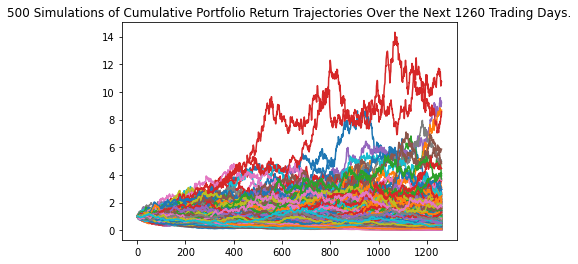

In [72]:
# Plot Simulation
sim_plot = MC_stock_dist.plot_simulation()
sim_plot

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

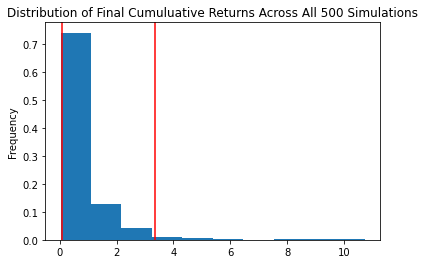

In [73]:
# Plot probability distribution and confidence intervals
dist_plot = MC_stock_dist.plot_distribution()
dist_plot

In [74]:
# Fetch summary statistics from the Monte Carlo simulation results
stocks_tbl = MC_stock_dist.summarize_cumulative_return()
col_stocks_tbl = pn.Column("<h4>Summary of Commulative Returns</h4>", stocks_tbl)
# Print summary statistics
print(stocks_tbl)

count           500.000000
mean              0.833095
std               1.105716
min               0.030850
25%               0.260026
50%               0.507400
75%               0.931017
max              10.731952
95% CI Lower      0.069536
95% CI Upper      3.364976
Name: 1260, dtype: float64


In [75]:
# Get the lower and upper 95% confidence
ci_lower = round(stocks_tbl[8],2)
ci_upper = round(stocks_tbl[9],2)


price_od_NG_on_last_day = df_historic2015_2019["Close"][-1]

# Calulate the lower and upper 95% Confidence values for the last sat of 2019
lower_value = ci_lower * df_historic2015_2019["Close"][-1] 
upper_value = ci_upper * df_historic2015_2019["Close"][-1] 

# format monte carlo results in words
sinfo = f"####There is a 95% chance that natural gas, which had a closing price of ${price_od_NG_on_last_day:,.2f} on the last trading day of 2019, will have a closing price at the end of the next 5 years within in a range of"f" ${lower_value:,.2f} and ${upper_value:,.2f}"

# Create a panel and append this info
col_sinfo = pn.Column(sinfo , scroll=False, width=900)

col_sinfo

Column(width=900)
    [0] Markdown(str)

Column
    [0] Markdown(str)
    [1] Tabs
        [0] Column(width=1000)
            [0] Markdown(str)
        [1] Column
            [0] Markdown(str)
            [1] Tabs
                [0] Column
                    [0] Markdown(str)
                    [1] Column
                        [0] Row(height=50, sizing_mode='fixed', width=800)
                            [0] Select(name='State', options=['PA', 'CT', 'IL', ...], value='CT')
                            [1] Checkbox(name='Lag Closing Price', value=True)
                            [2] Checkbox(name='Lag Temperature', value=True)
                            [3] IntSlider(end=3, name='Lag Period (in months)', start=-3, value=2, value_throttled=2)
                        [1] Plotly(Figure, name='interactive02567', viewport={'xaxis.range': ['2010-01-...})
                [1] Column
                    [0] Markdown(str)
                    [1] Column
                        [0] Row(height=50, sizing_mode='fixed', width=700)
                            [0] Select(name='Region', options=['US', 'PA', 'CT', ...], value='TX')
                            [1] Checkbox(name='Lag Closing Price', value=True)
                            [2] Checkbox(name='Lag Storage', value=True)
                            [3] IntSlider(end=3, name='Lag Period (in months)', start=-3, value=-1, value_throttled=-1)
                        [1] Plotly(Figure, name='interactive02595', viewport={'xaxis.range': ['2010-01-...})
                [2] Column
                    [0] Markdown(str)
                    [1] Column
                        [0] Row(height=50, sizing_mode='fixed', width=600)
                            [0] Select(name='Region', options=['US', 'PA', 'CT', ...], value='US')
                            [1] Checkbox(name='Lag Closing Price', value=True)
                            [2] Checkbox(name='Lag Consumption', value=True)
                            [3] IntSlider(end=3, name='Lag Period (in months)', start=-3, value=2, value_throttled=2)
                        [1] Plotly(Figure, name='interactive02672', viewport={'xaxis.range': ['2010-01-...})
        [2] Column
            [0] Markdown(str)
            [1] Tabs
                [0] Column
                    [0] Markdown(str)
                    [1] Column
                        [0] Row(height=50, sizing_mode='fixed', width=700)
                            [0] Select(name='Region', options=['US', 'PA', 'CT', ...], value='US')
                            [1] Checkbox(name='Lag Closing Price')
                            [2] Checkbox(name='Lag Storage')
                            [3] IntSlider(end=3, name='Lag Period (in months)', start=-3, value=1, value_throttled=1)
                        [1] Plotly(Figure, name='interactive02581', viewport={'xaxis.range': ['2010-01-...})
                [1] Column
                    [0] Markdown(str)
                    [1] Column
                        [0] Row(height=50, sizing_mode='fixed', width=600)
                            [0] Select(name='State', options=['PA', 'CT', 'IL', ...], value='PA')
                            [1] Checkbox(name='Lag Temperature')
                            [2] Checkbox(name='Lag Storage')
                            [3] IntSlider(end=3, name='Lag Period (in months)', start=-3, value_throttled=0)
                        [1] Plotly(Figure, name='interactive02607', viewport={'xaxis.range': [0, ...})
                [2] Column
                    [0] Markdown(str)
                    [1] Column
                        [0] Row(height=50, sizing_mode='fixed', width=600)
                            [0] Select(name='Region', options=['US', 'PA', 'CT', ...], value='US')
                            [1] Checkbox(name='Lag Consumption')
                            [2] Checkbox(name='Lag Storage')
                            [3] IntSlider(end=3, name='Lag Period (in months)', start=-3, value_throttled=0)
                        [1] Plotly(Figure, name='interactive0263
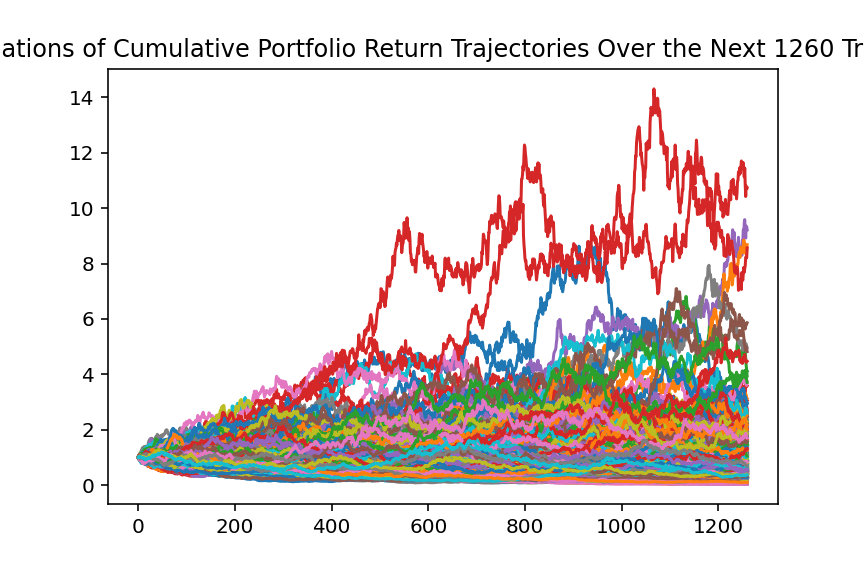
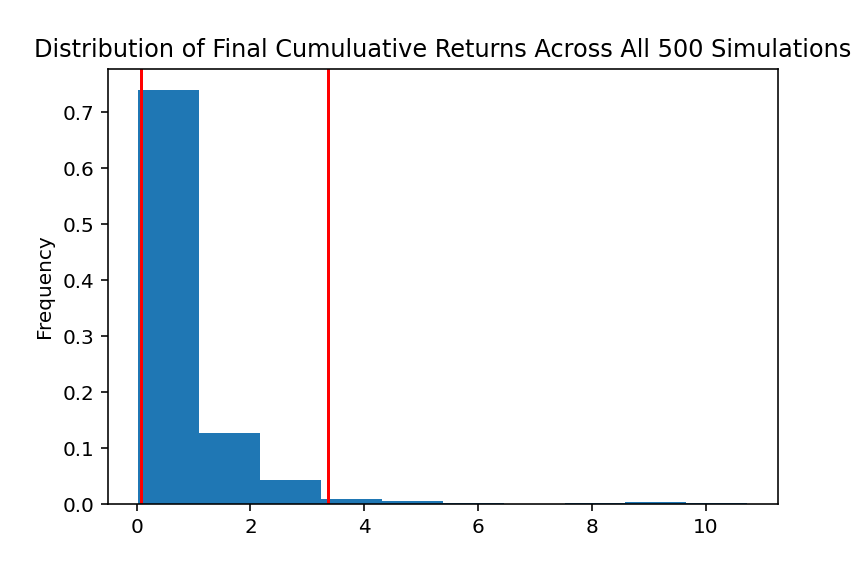

In [91]:
# Create the dashboard

# title of Project
title = "<h1>Natural Gas Analysis</h1> Contributors: Sabahat Khan, Zeray Admasu, and Daryl Redmond <br/>" 
#Overview of Project



sOverview = read_text_file(r"Dashboard_Text\Overview.txt")
col_Overview = pn.Column(sOverview, width=1000)
#"<h2>Falsifiable Hypothesis: Temperature does not influence the price of natural gas </h2>"\
#            + "Analysis: <li> Five years of daily natural gas closing prices and daily average temperature of five US cities </li>"\
#            + "Result: <li>We could not disprove our hypothesis </li>" 



# Nautal Gas Closing Price Analysis  Overview
closing_price_overview = read_text_file(r"Dashboard_Text\Closing_Price.txt")

#  Nautal Gas  Closing Price Tabs
closing_price_tabs = pn.Tabs(
                ("Closing Price & Temperature", pn.Column("<br/>", col_price_temp)),
                ("Closing Price & Storage", pn.Column("<br/>",col_price_storage)),
                ("Closing Price & Consumption", pn.Column("<br/>",col_price_consumption)),
)
# #  Nautal Gas  Closing Price TabsClosing Price Overview and Tabs in a column
col_closing_price = pn.Column(closing_price_overview, closing_price_tabs )


#  Nautal Gas  Storage Analysis  Overview
storage_overview = read_text_file(r"Dashboard_Text\Storage.txt")
"<h3>Natural Gas Storage Overview</h3> <br/>" + " Storage Data was collected from ...., downaloaded as as a CSV file. The data was weekly and ... "
#  Nautal Gas  Storage Tabs
storage_tabs = pn.Tabs(
                ("Storage & Closing Price", pn.Column("<br/>",col_storage_price)),
                ("Storage & Temperature", pn.Column("<br/>",col_storage_temp)),
                ("Storage & Consumption", pn.Column("<br/>",col_storage_comsumption)))
# Nautal Gas  Storage Overview and Tabs in a column
col_storage = pn.Column(storage_overview, storage_tabs )


#  Nautal Gas  Consumption Analysis  Overview
consumption_overview = read_text_file(r"Dashboard_Text\Consumption.txt")

#  Nautal Gas  Consumption Tabs
consumption_tabs = pn.Tabs(
                ("Consumption & Closing Price", pn.Column("<br/>",col_consumption_price)),
                ("Consumption & Temperature", pn.Column("<br/>",col_consumption_temp)),
                ("Consumption & Storage", pn.Column("<br/>",col_comsumption_storage)),
)
#  Nautal Gas  Consumption Overview and Tabs in a column
col_consumption = pn.Column(consumption_overview, consumption_tabs )

# Correlation Overview

correlation_overview = read_text_file(r"Dashboard_Text\Correlation.txt")
col_correlation = pn.Column(correlation_overview, col_heatmap)

#  Nautal Gas  Linear Regression Analysis  Overview
linear_regression_overview = read_text_file(r"Dashboard_Text\Linear_Regression.txt")

#  Nautal Gas  Consumption Column
col_linear_regression = pn.Column(linear_regression_overview, pn.Row(col_lrg_price_temp, col_lrg_storage_con), 
                                  pn.Row(col_lrg_temp_consumption, col_lrg_storage_temp), "<br/>", col_out_of_sample_pa_plot)




#  Nautal Gas  Monte Carlo Simulation  Overview
monte_carlo_overview = read_text_file(r"Dashboard_Text\Monte_Carlo.txt")
#"<h3>Monte Carlo Simulation</h3> Monte Carlo Simulation of Natital Closing Price using 5 year data from 2010-2014, 500 simulations. "
#  Nautal Gas  Monte Carlo Simulation  Column
col_monte_carlo = pn.Column(monte_carlo_overview, pn.Row(sim_plot.figure, dist_plot.figure), col_stocks_tbl, col_sinfo)


# Dashboard tabs
dashboard_tabs = pn.Tabs( (" Welcome", col_Overview), 
                (" Stock Closing Price Analysis", col_closing_price), 
                (" Storage Analysis", col_storage),
                (" Consumption Analysis" , col_consumption),
                (" Correlation Analysis" , col_correlation),                 
                (" Linear Regression Analysis" , col_linear_regression),
                (" Monte Carlo Simulation" , col_monte_carlo)
                )
# Dashboard
dashboard = pn.Column(title, dashboard_tabs)
dashboard


In [92]:
#Open another tab/window and launch the bokeh server and show the dashboard
dashboard.show()


Launching server at http://localhost:60997
